# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [3]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
%reload_ext autoreload
%autoreload 2

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
# # if run in Udacity WorkStation:

!pip -q install ./python

from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [ ]:
# #if run in a local mac, drl python environment:

# from unityagents import UnityEnvironment
# import numpy as np
# env = UnityEnvironment(file_name="Tennis.app", no_graphics=True)

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


[autoreload of prompt_toolkit failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/opt/conda/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/opt/conda/lib/python3.6/site-packages/prompt_toolkit/__init__.py", line 18, in <module>
    from .shortcuts import PromptSession, prompt, print_formatted_text
ImportError: cannot import name 'PromptSession'
]
[autor

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [7]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.09000000171363354


### 4. Train agents with MADDPG

In [4]:
import os
import torch
import numpy as np
import time

from collections import deque
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from nnmodels_tennis import Actor, Critic
from config_settings import Args
from replay_buffer import ReplayBuffer
from maddpg_agents import MADDPG


#For tensorboard at l
# !pip install tensorboardX  
# !pip install -U protobuf  

#from tensorboardX import SummaryWriter
#import tensorflow as tf

agent = MADDPG()
args=Args()
max_t=args.max_steps
print("num_episodes=", args.num_episodes)
print("scoreGoal=",args.scoreGoal)

class ScoreTracker():
    def __init__(self):
        self.score = None
        self.avg_score = None
        self.std_dev = None
        self.scores = []                          
        self.avg_scores = []                      
        self.scores_lastNepisodes_deque = deque(maxlen=args.print_every)    
        self.best_avg_score = -9999               
        self.time_start = time.time()             
        self.total_steps = 0                      
        #self.writer = SummaryWriter()
        if not(os.path.exists(os.getcwd()+os.sep+"checkpoints")): os.mkdir("./checkpoints")

    def update_score(self, steps, rewards, i_episode):
        """Update scoreTracker every episode."""
        self.total_steps += steps
        self.score = sum(rewards)
        self.scores_lastNepisodes_deque.append(self.score)
        self.scores.append(self.score)
        self.avg_score = np.mean(self.scores_lastNepisodes_deque)
        self.avg_scores.append(self.avg_score)
        self.std_dev = np.std(self.scores_lastNepisodes_deque)

        if self.avg_score > self.best_avg_score : 
            self.best_avg_score = self.avg_score

    def is_solved(self, i_episode, scoreGoal):
        return (self.avg_score >= scoreGoal) 

    def sendTotensorboard(self, i_episode, steps, scoreTracker_format, bufferSize, noise_weight,
                          critic_loss_01, 
                          critic_loss_02,
                          actor_loss_01, 
                          actor_loss_02,
                          rewards_01, 
                          rewards_02):
        
        common_scoreTracker = 'Episode:{:3}   Avg Score (over last N episodes) :{:3.3f}'.format(i_episode, self.avg_score)
        print('\rEpisode:{:3}   Avg Score (over last N episodes):{:3.3f}'.format(i_episode, self.avg_score), end='') #+ scoreTracker_format.format(bufferSize, noise_weight)

# Worked only at local Mac with tensorboard
#         self.writer.add_scalar('agent1/critic_loss', critic_loss_01, i_episode)
#         self.writer.add_scalar('agent2/critic_loss', critic_loss_02, i_episode)
#         self.writer.add_scalar('agent1/actor_loss', actor_loss_01, i_episode)
#         self.writer.add_scalar('agent2/actor_loss', actor_loss_02, i_episode)
#         self.writer.add_scalar('agent1/reward', rewards_01, i_episode)
#         self.writer.add_scalar('agent2/reward', rewards_02, i_episode)

    def stdout_everyNepisode(self, i_episode, scoreTracker_format, *args):
        timeelapse = int(time.time() - self.time_start)
        print('\n                                              |  TimeElapsed: {:3} sec |'.format(timeelapse))

            
def train_multiagents(env, agent, n_episodes=args.num_episodes, 
                      max_t=args.max_steps, 
                      scoreGoal=args.scoreGoal, 
                      best_margin=0.35):
    
    scoreTracker = ScoreTracker()
    scoreTracker_format = '  [scoreTracker]  Buffer: {:4}   NoiseW: {:.3}'
    isSolved = False

    for i_episode in range(1, n_episodes+1):
        rewards = []
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations               # get the current state  
        for t in range(max_t):
            action = agent.act(state)  
            env_info = env.step(action)[brain_name]       # Take action          
            next_state = env_info.vector_observations     # get next state
            reward = env_info.rewards                     # get reward
            done = env_info.local_done          
            agent.step(state, action, reward, next_state, done)
            state = next_state
            rewards.append(reward)       
            if any(done): break

        bufferSize = len(agent.memory)
        eachAgentrewards_lst = []  
        for i in range(agent.n_agents):
            eachAgent_reward = 0
            for step in rewards:
                eachAgent_reward += step[i]
            eachAgentrewards_lst.append(eachAgent_reward)
            
        scoreTracker.update_score(t, [np.max(eachAgentrewards_lst)], i_episode)
        scoreTracker.sendTotensorboard(i_episode, t, scoreTracker_format, bufferSize, 
                                        agent.noise_weight,
                                        agent.agents[0].critic_loss, 
                                        agent.agents[1].critic_loss,
                                        agent.agents[0].actor_loss, 
                                        agent.agents[1].actor_loss,
                                        eachAgentrewards_lst[0], 
                                        eachAgentrewards_lst[1])

        if i_episode % args.print_every == 0:
            scoreTracker.stdout_everyNepisode(i_episode, scoreTracker_format, bufferSize, agent.noise_weight)
            for i, save_agent in enumerate(agent.agents):
                torch.save(save_agent.actor_local.state_dict(), './checkpoints/p3_episode_' + str(i_episode) + '_agent_'+ str(i) + '_actor.pth')
                torch.save(save_agent.critic_local.state_dict(), './checkpoints/p3_episode_' + str(i_episode) + '_agent_'+ str(i) + '_critic.pth')

        if scoreTracker.is_solved(i_episode, scoreGoal):
            isSolved = True
            timeelapse_t = int(time.time() - scoreTracker.time_start)
            print('\nSolved in {:d} episodes, TimeElapsed: {:3} sec !'.format(i_episode, timeelapse_t))
           
            for i, save_agent in enumerate(agent.agents):
                torch.save(save_agent.actor_local.state_dict(), './checkpoints/p3_best_agent_' + str(i) + '_actor.pth')
                torch.save(save_agent.critic_local.state_dict(), './checkpoints/p3_best_agent_' + str(i) + '_critic.pth')
                print("\nSolved actor pth filename:", './checkpoints/p3_best_agent_' + str(i) + '_actor.pth')
                print("\nSolved critic pth filename:", './checkpoints/p3_best_agent_' + str(i) + '_critic.pth')
            break
                
    return scoreTracker
                    
scoreTracker = train_multiagents(env, agent)


device= cuda:0
num_episodes= 6000
scoreGoal= 0.5
Episode:100   Avg Score (over last N episodes):0.012
                                              |  TimeElapsed:  62 sec |
Episode:200   Avg Score (over last N episodes):0.010
                                              |  TimeElapsed: 141 sec |
Episode:300   Avg Score (over last N episodes):0.004
                                              |  TimeElapsed: 213 sec |
Episode:400   Avg Score (over last N episodes):0.001
                                              |  TimeElapsed: 283 sec |
Episode:500   Avg Score (over last N episodes):0.000
                                              |  TimeElapsed: 353 sec |
Episode:600   Avg Score (over last N episodes):0.005
                                              |  TimeElapsed: 429 sec |
Episode:700   Avg Score (over last N episodes):0.019
                                              |  TimeElapsed: 521 sec |
Episode:800   Avg Score (over last N episodes):0.024
                       

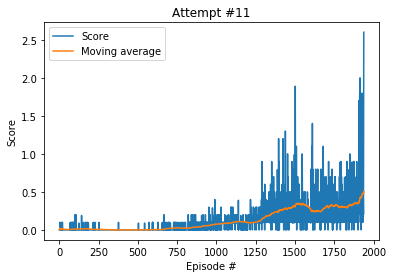

In [6]:
#Plot Score
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scoreTracker.scores)+1), scoreTracker.scores )
plt.plot(np.arange(1, len(scoreTracker.avg_scores)+1), scoreTracker.avg_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
ax.set_title('Attempt #11')
ax.legend(['Score','Moving average'])
plt.show()

### To visualize NN training process in TensorBoard from local Mac: 


(drlnd) parksoy@~/Desktop/deep-reinforcement-learning/p3_collab-compet$tensorboard --logdir ./ --host=127.0.0.1   

TensorBoard 1.7.0 at http://127.0.0.1:6006 (Press CTRL+C to quit)


When finished, you can close the environment.

In [6]:
env.close()